In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os

plt.style.use('ggplot')

# Elveovervåkingsprogrammet - average monthly temperatures

This notebook calculates average monthly temperatures for the 20 main rivers in the 2018-19 monitoring programme. Data come from a variety of sources, so the workflow is a bit messy. See e-mail from Cathrine received 16.10.2019 at 08.58 for more details. 

**Note:** The most recent temperature data is Hydra-II is located in a slightly different place to the usual discharge series. To get to the temperature data, first start the **DAGUT** program (as usual) and click **Hent** to open the station selector window. At the top of this window, open the drop-down list and choose **HYKVAL** (second item down) then search for the station of interest. Temperature series have variable code 1003 in the database.

## 1. Get manual data from RESA2

The code below gets all the temperature data from RESA2 and calculates monthly averages.

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


In [3]:
# Year of interest
year = 2018

In [4]:
# Find project
prj_df = nivapy.da.search_resa_projects("project_name LIKE '%lveovervåking%'", eng)
prj_df

,project_id,project_number,project_name,contact_person,project_description
0,4230,O 16384,Elveovervåkingsprogrammet,None,Videreføring av RID. Tilførsler fra elver til ...


In [5]:
# Get stations
stn_df = nivapy.da.select_resa_project_stations(prj_df, eng)
stn_df

,station_id,station_code,station_name,latitude,longitude,altitude
0,29612,BUSEDRA,Drammenselva,NaN,NaN,None
1,29615,VESENUM,Numedalslågen,NaN,NaN,None
2,29613,TELESKI,Skienselva,NaN,NaN,None
3,30019,AAGEVEG,Vegårdselva,58.669996,8.980983,None
4,29614,VAGEOTR,Otra,NaN,NaN,None
5,29832,ROGEBJE,Bjerkreimselva,NaN,NaN,None
6,29783,ROGEORR,Orreelva,NaN,NaN,None
7,29617,ØSTEGLO,Glomma ved Sarpsfoss,59.279802,11.134111,None
8,36225,OSLEALN,Alna,59.905091,10.791359,None
9,29837,ROGEVIK,Vikedalselva,NaN,NaN,None


In [6]:
# Not interested in TROEMÅL2
stn_df = stn_df.query('station_id != 38005')

In [7]:
# Find ID for temp var
par_grid = nivapy.da.select_resa_station_parameters(stn_df, 
                                                    f'{year}-01-01',
                                                    f'{year}-12-31',
                                                    eng)
par_grid.df.query('parameter_name == "Temp"')

31 parameters available for the selected stations and dates.


/opt/conda/lib/python3.7/site-packages/pandas/core/base.py:1629: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,parameter_id,parameter_name,unit
26,125,Temp,oC


In [8]:
# Get temp data 
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_df,
                                                      [125,],
                                                      f'{year}-01-01',
                                                      f'{year}-12-31',
                                                      eng)

wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,Temp_oC
,,,,,,,
0,29612,BUSEDRA,Drammenselva,2018-01-02 11:00:00,0,0,1.0
1,29612,BUSEDRA,Drammenselva,2018-02-06 09:30:00,0,0,0.1
2,29612,BUSEDRA,Drammenselva,2018-03-06 09:00:00,0,0,0.2
3,29612,BUSEDRA,Drammenselva,2018-04-03 09:30:00,0,0,0.7
4,29612,BUSEDRA,Drammenselva,2018-05-08 07:30:00,0,0,5.5


In [9]:
# Print number of measurements in year for each site   
print(wc_df[['station_id', 'Temp_oC']].groupby('station_id').count())

# Aggregate to monthly
wc_df['month'] = wc_df['sample_date'].dt.month
agg = wc_df[['station_id', 'month', 'Temp_oC']].groupby(['station_id', 'month'])
mon_df = agg.mean().reset_index()

            Temp_oC
station_id         
29612            16
29613             2
29615             4
29617            16
29778             2
29782             1
29819            12
29820            12
29822            12
29832            10
29842            12
29844            12
29848            12
36225            12


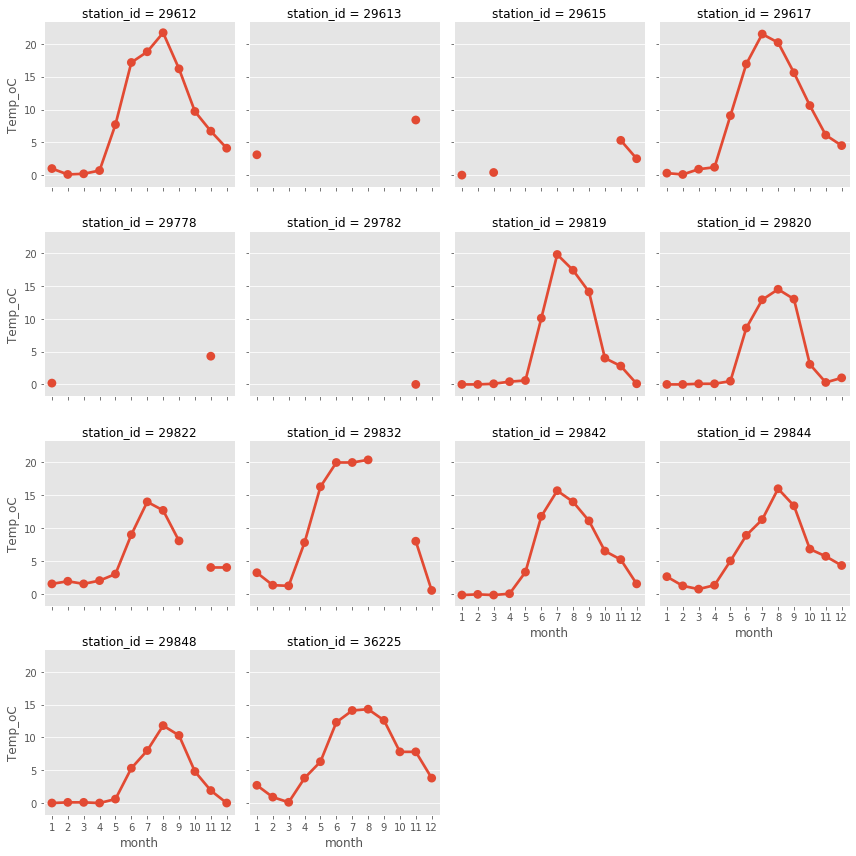

In [10]:
# Plot monthly means
sn.catplot(x='month', 
           y='Temp_oC', 
           data=mon_df, 
           col='station_id',  
           col_wrap=4, 
           kind='point', 
           height=3)

# Save
out_path = f'../../../Data/temperature_data/temp_{year}-{year - 1999}/other/temps_manual_{year}.png'
plt.savefig(out_path, dpi=300)

In [11]:
# Pivot to "wide" format
man_df = mon_df.pivot(index='station_id', 
                      columns='month', 
                      values='Temp_oC')

man_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29612,1.0,0.1,0.20,0.70,7.700000,17.166667,18.8,21.7,16.20,9.70,6.7,4.1
29613,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.4,NaN
29615,0.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.3,2.5
29617,0.3,0.1,0.90,1.20,9.066667,16.933333,21.5,20.2,15.60,10.60,6.1,4.5
29778,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,NaN
29782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
29819,0.0,0.0,0.10,0.42,0.600000,10.100000,19.8,17.4,14.10,4.01,2.8,0.1
29820,0.0,0.0,0.10,0.10,0.500000,8.600000,12.9,14.5,13.00,3.06,0.3,1.0
29822,1.5,1.9,1.50,2.00,3.000000,9.000000,14.0,12.7,8.05,NaN,4.0,4.0


Based on Cathrine's spreadsheet here

    K:\Prosjekter\Ferskvann\16384 Elveovervåkingsprogrammet\2019\4. Data\6. Vanntemperatur\Grunnprogrammet\2018_TempData_Overview.xlsx
    
we will use the data from RESA for 9 stations. Filter to just these.

In [12]:
# Filter to desired stations for RESA
resa_list = [29617, 36225, 29612, 29832, 
             29842, 29822, 29844, 29820, 29819]
man_df = man_df.query('station_id in @resa_list')

## 2. TinyTag data

TinyTags are deployed in 7 rivers and the sensors are swapped in the middle of the year, so we need to splice together two data files for each location. The TinyTag are often recording even when they're out of the water, so it's important to know the date when each logger was taken in/set out. See Liv Bente's spreadsheet here:

    K:\Prosjekter\Ferskvann\16384 Elveovervåkingsprogrammet\2019\4. Data\6. Vanntemperatur\Grunnprogrammet\1. TinyTag tempsensorer\1. Oversikt inn ut setting templogger RID hoved 2014-15-16-17-18-19_lbs.xlsx
    
**Note:** The date format in the text files sometimes changes (e.g from `%d.%m.%Y %H.%M.%S,%f` to `%d.%m.%Y %H:%M:%S,%f`), so it might be necessary to modify the code below.

In [13]:
# Dates from Liv Bente's spreadsheet for 2018
swap_dates = {29615:['Numedalslagen', '2018-06-04 09:20'],
              29613:['Skienselva',    '2018-06-11 15:10'],
              29614:['Otra',          '2018-06-04 13:50'],
              29783:['Orreelva',      '2018-06-04 08:40'],
              29821:['Vosso',         '2018-06-04 08:40'],
              29782:['Vefsna',        '2018-07-10 12:20'],
              29779:['Altaelva',      '2018-08-08 12:30']}

# Base folder (with tidied file names)
data_fold = r'../../../Data/temperature_data'

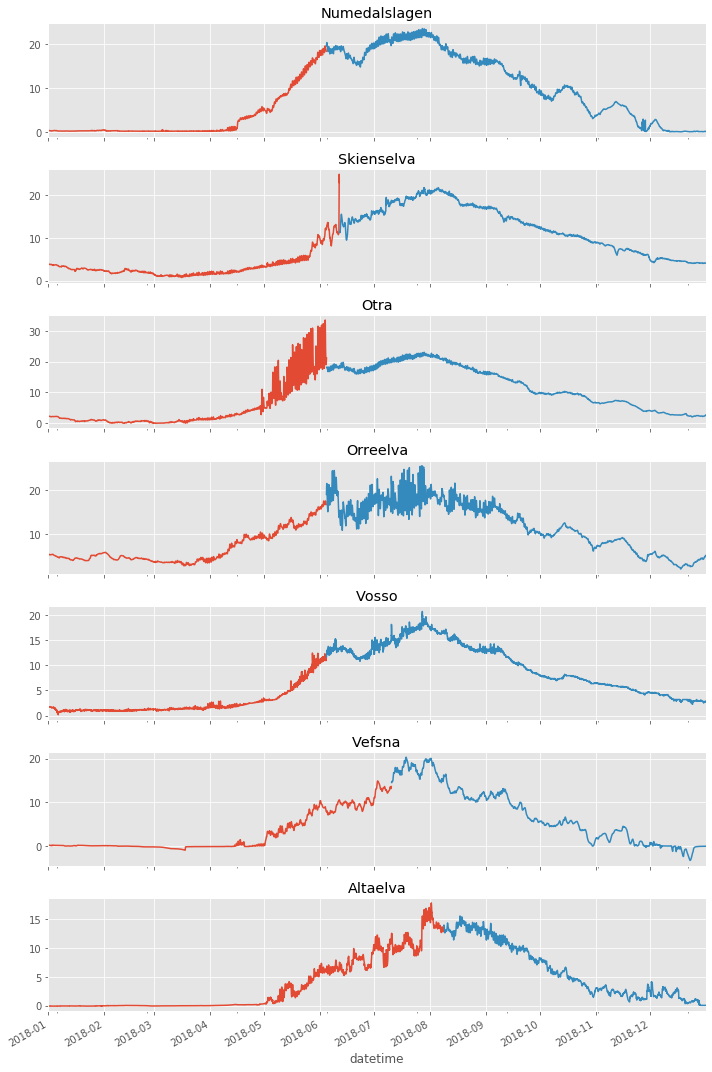

In [14]:
# Container for output
df_list = []

# Setup plot
fig, axes = plt.subplots(nrows=7, ncols=1, 
                         figsize=(10,15), 
                         sharex=True)

# Loop over stations
for idx, stn_id in enumerate(swap_dates.keys()):
    # Get stn
    stn = swap_dates[stn_id][0]
    
    # Get data paths
    path_prev_yr = os.path.join(data_fold, f'temp_{year - 1}-{year - 2000}/tiny_tag/{stn}_{year - 1}-{year - 2000}.txt')
    path_yr = os.path.join(data_fold, f'temp_{year}-{year - 1999}/tiny_tag/{stn}_{year}-{year - 1999}.txt')

    # Parse series 1
    df_prev_yr = pd.read_csv(path_prev_yr, 
                             delim_whitespace=True, 
                             skiprows=2, 
                             names=['date', 'time', 'temp'], 
                             decimal=',')
    df_prev_yr['datetime'] = df_prev_yr['date'] + ' ' + df_prev_yr['time']
    df_prev_yr['datetime'] = pd.to_datetime(df_prev_yr['datetime'], 
                                            format='%d.%m.%Y %H.%M.%S,%f')
    df_prev_yr.set_index('datetime', inplace=True)
    del df_prev_yr['date'], df_prev_yr['time']

    # Parse series 2
    df_yr = pd.read_csv(path_yr, 
                        delim_whitespace=True, 
                        skiprows=2, 
                        names=['date', 'time', 'temp'], 
                        decimal=',')
    df_yr['datetime'] = df_yr['date'] + ' ' + df_yr['time']
    df_yr['datetime'] = pd.to_datetime(df_yr['datetime'], 
                                       format='%d.%m.%Y %H:%M:%S,%f')
    df_yr.set_index('datetime', inplace=True)
    del df_yr['date'], df_yr['time']

    # Get date logger changed
    swap_dt = pd.to_datetime(swap_dates[stn_id][1])
    swap_dt_plus1 = swap_dt + pd.DateOffset(hours=3) # Skip 3 hrs to allow time for re-equilibration
    
    # Truncate series 1
    df_prev_yr = df_prev_yr.truncate(before='%s-01-01 00:00' % year,
                                     after=swap_dt)
    
    # Truncate series 2
    df_yr = df_yr.truncate(before=swap_dt_plus1,
                           after='%s-12-31 23:59' % year)    

    # Combine
    df = pd.merge(df_prev_yr, df_yr, how='outer', 
                  left_index=True, right_index=True)
    
    # Plot
    df.plot(ax=axes[idx], legend=False)
    axes[idx].set_title(stn)
    
    # Concat to single series
    df = pd.concat([df_prev_yr, df_yr], axis=0, sort=True)

    # Monthly avgs.
    df = df.resample('M').mean()
    
    # Add to output
    df['station_id'] = stn_id
    df_list.append(df)

plt.tight_layout()

In [15]:
# Combine results
df = pd.concat(df_list, axis=0, sort=True)
df.columns = ['station_id', 'Temp_oC']
df['month'] = df.index.month
df.reset_index(inplace=True)
tt_df = df.pivot(index='station_id', 
                 columns='month', 
                 values='Temp_oC')
tt_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29613,2.930753,2.060580,1.241036,2.322236,5.169301,13.051365,18.622151,19.052634,14.605000,10.643678,7.329458,4.567339
29614,1.233911,0.393006,0.622678,3.104847,14.113522,18.228872,20.923051,19.095591,13.455958,9.184483,6.116278,2.874422
29615,0.225954,0.176042,0.157631,2.046472,10.752634,17.940557,21.546801,17.859368,13.127028,7.819235,4.113806,0.490148
29779,-0.070860,-0.010670,-0.032948,0.120389,2.686129,7.000111,10.917406,13.628502,10.292069,4.997503,2.130792,1.451048
29782,0.109220,-0.041830,-0.330942,0.063778,4.908575,9.257208,16.373158,13.276640,9.457222,4.293597,1.921514,-0.429745
29783,4.825000,4.601607,3.687416,7.463486,12.124462,16.488312,18.135941,17.177903,13.545389,10.060859,7.147278,4.029180
29821,1.073320,1.071354,1.332167,2.109042,5.971277,12.430683,15.878172,14.798978,10.888847,7.377812,5.500583,3.459086


## 3. Other logger data

Other temperature data is also available for Målselv and Vegårdselva (= Storelva/Lundevann)

### 3.1. Målselva

In [16]:
# Read raw data
in_xlsx = f'../../../Data/temperature_data/temp_{year}-{year - 1999}/other/malselva_{year}.xlsx'
df = pd.read_excel(in_xlsx, sheet_name='Temp')
del df['StationName']
df.set_index('Date', inplace=True)

# Resample
df = df.resample('M').mean()

# Tidy
df.columns = ['Temp_oC']
df['month'] = df.index.month
df.reset_index(inplace=True)
del df['Date']
df['station_id'] = 29848

mal_df = df.pivot(index='station_id', 
                  columns='month', 
                  values='Temp_oC')

mal_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29848,0.004618,0.004196,0.004601,0.009154,4.383942,7.107197,13.890796,12.982245,8.577986,2.827812,0.825025,0.030462


### 3.2. Vegårdselva

In [17]:
# Read raw data
in_xlsx = f'../../../Data/temperature_data/temp_{year}-{year - 1999}/other/vegardselva_{year}.xlsx'
df = pd.read_excel(in_xlsx, sheet_name='Temp')
del df['StationName']
df.set_index('Date', inplace=True)

# Resample
df = df.resample('M').mean()

# Tidy
df.columns = ['Temp_oC']
df['month'] = df.index.month
df.reset_index(inplace=True)
del df['Date']
df['station_id'] = 30019

veg_df = df.pivot(index='station_id', 
                  columns='month', 
                  values='Temp_oC')

veg_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
30019,1.624213,1.137054,0.779085,2.758486,15.679622,21.410956,23.814833,20.222386,15.316672,10.704636,7.477861,4.142749


## 4. NVE data

For 2018, NVE datasets are only required for Vikedalselva and Orkla. Note that in previous years we have used more NVE datasets. These are commented out below, but might be relevant again in future.

In [18]:
# Dict mapping NVE temp codes to RESA IDs
stn_id_dict = {
               #'2_1087':29617,
               #'12_298':29612,
               #'15_115':29615,
               #'16_207':29613,
               #'21_79':29614,
               #'27_29':29832,
               '38_2':29837,
               #'62_30':29821,
               #'84_23':29842,
               '121_62':29778,
               #'151_32':29782,
               #'246_11':29819,
              }

# Data folder
data_fold = f'../../../Data/temperature_data/temp_{year}-{year - 1999}/hydra-ii'

# List for data
df_list = []

# Loop over sites
for stn_cd in stn_id_dict.keys():
    # Read data
    file_path = os.path.join(data_fold, '%s.txt' % stn_cd)
    df = pd.read_csv(file_path, skiprows=2, names=['date', 'Temp_oC'], na_values=-9999)
    df['date'] = pd.to_datetime(df['date'], 
                                format='%Y.%m.%d %H:%M')
    df.set_index('date', inplace=True)
    
    # Resample
    df = df.resample('M').mean()
    
    # Convert index to month
    df.index = df.index.month
    df.index.name = 'month'
    
    # Change column to site id
    df.columns = [stn_id_dict[stn_cd], ]
    
    # Transpose and append
    df_list.append(df.T)

# Combine
nve_df = pd.concat(df_list, axis=0, sort=True)
nve_df.index.name = 'station_id'
nve_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29837,1.541979,0.807631,0.782195,3.543564,10.995256,16.422877,19.497449,15.569449,12.044600,8.441198,5.216732,3.106447
29778,0.405867,0.471068,0.570972,2.043184,7.888955,11.089533,14.566958,12.485848,9.280306,4.336453,1.744859,0.820593


## Combine

In [19]:
# Melt all and combine
# RESA
man_df2 = man_df.reset_index().melt(id_vars='station_id')
man_df2['source'] = 'Manual'

# TinyTag
tt_df2 = tt_df.reset_index().melt(id_vars='station_id')
tt_df2['source'] = 'TinyTag'

# Other
mal_df2 = mal_df.reset_index().melt(id_vars='station_id')
mal_df2['source'] = 'Other'

veg_df2 = veg_df.reset_index().melt(id_vars='station_id')
veg_df2['source'] = 'Other'

# NVE
nve_df2 = nve_df.reset_index().melt(id_vars='station_id')
nve_df2['source'] = 'NVE'

# Combine
df = pd.concat([man_df2, tt_df2, mal_df2, veg_df2, nve_df2], axis=0, sort=True)

# Join stn codes
df = pd.merge(df, 
              stn_df[['station_id', 'station_code']], 
              how='left', 
              on='station_id')
del df['station_id']
df.columns = ['Month', 'Source', 'Temperature (C)', 'Station code']

df.head()

,Month,Source,Temperature (C),Station code
0,1,Manual,1.0,BUSEDRA
1,1,Manual,0.3,ØSTEGLO
2,1,Manual,0.0,FINEPAS
3,1,Manual,0.0,FINETAN
4,1,Manual,1.5,MROEDRI


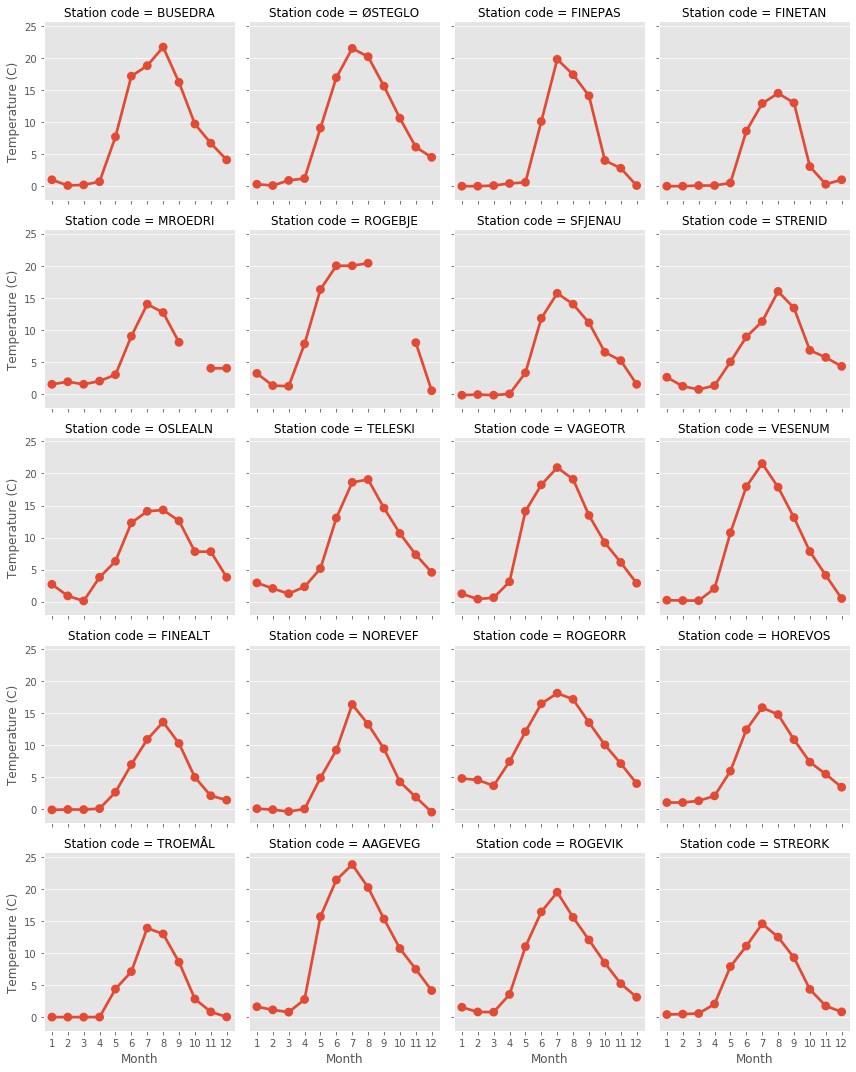

In [20]:
# Plot
sn.catplot(x='Month', 
           y='Temperature (C)', 
           data=df, 
           #hue='Source', 
           col='Station code', 
           col_wrap=4, 
           height=3, 
           #linestyles=['--', '--', '--', '--'],
           kind='point')

# Save
out_path = f'../../../Data/temperature_data/temp_{year}-{year - 1999}/temps_all_sources_{year}.png'
plt.savefig(out_path, dpi=300)

## 5. Format for output

In [21]:
# Combine
df = pd.concat([man_df, tt_df, mal_df, veg_df, nve_df], axis=0, sort=True)
df.reset_index(inplace=True)

# Join station details
df = pd.merge(df, stn_df, how='left', on='station_id')

# Reorder
df = df[['station_id', 'station_code', 'station_name', 'latitude', 'longitude', 'altitude']+list(range(1,13))]
del df['latitude'], df['longitude'], df['altitude']

# Round values
df = df.round(2)

# Save output
out_csv = f'../../../Data/temperature_data/temp_{year}-{year - 1999}/monthly_avg_temps_{year}-{year - 1999}.csv'
df.to_csv(out_csv, encoding='utf-8', index=False)

df

,station_id,station_code,station_name,1,2,3,4,5,6,7,8,9,10,11,12
0,29612,BUSEDRA,Drammenselva,1.00,0.10,0.20,0.70,7.70,17.17,18.80,21.70,16.20,9.70,6.70,4.10
1,29617,ØSTEGLO,Glomma ved Sarpsfoss,0.30,0.10,0.90,1.20,9.07,16.93,21.50,20.20,15.60,10.60,6.10,4.50
2,29819,FINEPAS,Pasvikelva,0.00,0.00,0.10,0.42,0.60,10.10,19.80,17.40,14.10,4.01,2.80,0.10
3,29820,FINETAN,Tanaelva,0.00,0.00,0.10,0.10,0.50,8.60,12.90,14.50,13.00,3.06,0.30,1.00
4,29822,MROEDRI,Driva,1.50,1.90,1.50,2.00,3.00,9.00,14.00,12.70,8.05,NaN,4.00,4.00
5,29832,ROGEBJE,Bjerkreimselva,3.20,1.30,1.20,7.80,16.30,20.00,20.00,20.40,NaN,NaN,8.00,0.50
6,29842,SFJENAU,Nausta,-0.20,-0.10,-0.20,0.00,3.30,11.80,15.70,14.00,11.10,6.50,5.20,1.50
7,29844,STRENID,Nidelva (Tr.heim),2.60,1.20,0.70,1.30,5.00,8.90,11.30,16.00,13.40,6.80,5.70,4.30
8,36225,OSLEALN,Alna,2.70,0.90,0.11,3.80,6.30,12.30,14.10,14.30,12.60,7.80,7.80,3.80
9,29613,TELESKI,Skienselva,2.93,2.06,1.24,2.32,5.17,13.05,18.62,19.05,14.61,10.64,7.33,4.57
